In [1]:
# Imports
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns


#### Load and clean GPS Data

In [2]:
import pandas as pd

# Load the GPS data from the .log file
data_gps1 = pd.read_csv('./Data/1/gps/gps_2023-04-20.log', sep=';')

# Data cleaning and formatting
data_gps1['Latitude'] = data_gps1['Latitude'].str.rstrip('N').astype(float)
data_gps1['Longitude'] = data_gps1['Longitude'].str.rstrip('E').astype(float)

# Merge 'Date' and 'Time' columns into a single datetime column
data_gps1['Datetime'] = pd.to_datetime(data_gps1['Date'] + ' ' + data_gps1['Time'], format='%d/%m/%Y %H:%M:%S')

# Convert the datetime column to Unix format in milliseconds
data_gps1['UnixTimeStampInMsec'] = (data_gps1['Datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta(milliseconds=1)

# Drop the original 'Date' and 'Time' columns as they are no longer needed
data_gps1.drop(columns=['Date', 'Time'], inplace=True)

# Drop 'MagneticVariation' column as it is not relevant to the problem
data_gps1.drop(columns=['MagneticVariation'], inplace=True)

# Filter rows where the date is '2023-04-20'
data_gps1 = data_gps1[data_gps1['Datetime'].dt.date == pd.to_datetime('2023-04-20').date()]

print(data_gps1)


       Latitude  Longitude  Speed  TrackAngle            Datetime  \
6938    58.3098    15.1327   2.42      340.11 2023-04-20 00:00:00   
6939    58.3098    15.1327   2.90      336.39 2023-04-20 00:00:01   
6940    58.3098    15.1326   3.53      348.29 2023-04-20 00:00:02   
6941    58.3099    15.1326   4.02      345.83 2023-04-20 00:00:03   
6942    58.3099    15.1326   4.54      343.28 2023-04-20 00:00:04   
...         ...        ...    ...         ...                 ...   
83740   59.5635    17.8822   0.66      286.10 2023-04-20 21:59:08   
83741   59.5635    17.8822   0.24      286.10 2023-04-20 21:59:09   
83742   59.5635    17.8822   0.21      286.10 2023-04-20 21:59:10   
83743   59.5635    17.8822   1.39      286.10 2023-04-20 21:59:11   
83744   59.5635    17.8822   0.05      286.10 2023-04-20 21:59:12   

       UnixTimeStampInMsec  
6938         1681948800000  
6939         1681948801000  
6940         1681948802000  
6941         1681948803000  
6942         1681948804000

In [3]:
# Rearrange columns with 'UnixTimeStampInMsec' at the beginning
data_gps1 = data_gps1[['UnixTimeStampInMsec'] + [col for col in data_gps1.columns if col not in ['Date', 'Time', 'UnixTimeStampInMsec']]]

# Drop the original 'Date' and 'Time' columns as they are no longer needed
data_gps1.drop(columns=['Datetime'], inplace=True)

print(data_gps1)


       UnixTimeStampInMsec  Latitude  Longitude  Speed  TrackAngle
6938         1681948800000   58.3098    15.1327   2.42      340.11
6939         1681948801000   58.3098    15.1327   2.90      336.39
6940         1681948802000   58.3098    15.1326   3.53      348.29
6941         1681948803000   58.3099    15.1326   4.02      345.83
6942         1681948804000   58.3099    15.1326   4.54      343.28
...                    ...       ...        ...    ...         ...
83740        1682027948000   59.5635    17.8822   0.66      286.10
83741        1682027949000   59.5635    17.8822   0.24      286.10
83742        1682027950000   59.5635    17.8822   0.21      286.10
83743        1682027951000   59.5635    17.8822   1.39      286.10
83744        1682027952000   59.5635    17.8822   0.05      286.10

[76807 rows x 5 columns]


In [4]:
# Remove rows with duplicate entries in UnixTimeStampInMsec
data_gps1 = data_gps1.drop_duplicates(subset=['UnixTimeStampInMsec'], keep='first')

# Remove rows with empty or null values in any field
data_gps1 = data_gps1.dropna()

print(data_gps1)

# Note: Attempting to drop duplicate entries; but data doesnot contain entries against duplicate
# timestamps.


       UnixTimeStampInMsec  Latitude  Longitude  Speed  TrackAngle
6938         1681948800000   58.3098    15.1327   2.42      340.11
6939         1681948801000   58.3098    15.1327   2.90      336.39
6940         1681948802000   58.3098    15.1326   3.53      348.29
6941         1681948803000   58.3099    15.1326   4.02      345.83
6942         1681948804000   58.3099    15.1326   4.54      343.28
...                    ...       ...        ...    ...         ...
83740        1682027948000   59.5635    17.8822   0.66      286.10
83741        1682027949000   59.5635    17.8822   0.24      286.10
83742        1682027950000   59.5635    17.8822   0.21      286.10
83743        1682027951000   59.5635    17.8822   1.39      286.10
83744        1682027952000   59.5635    17.8822   0.05      286.10

[76806 rows x 5 columns]


In [5]:
# Summary statistics
print("Summary Statistics:")
print(data_gps1.describe())

Summary Statistics:
       UnixTimeStampInMsec      Latitude     Longitude         Speed  \
count         7.680600e+04  76806.000000  76806.000000  76806.000000   
mean          1.681988e+12     59.456450     17.416861      8.643107   
std           2.282410e+07      0.261028      0.725235     17.413971   
min           1.681949e+12     58.309800     15.129700      0.000000   
25%           1.681969e+12     59.402400     16.505200      0.260000   
50%           1.681988e+12     59.563400     17.882000      0.470000   
75%           1.682008e+12     59.563500     17.882100      1.000000   
max           1.682028e+12     59.655000     17.927000     55.920000   

         TrackAngle  
count  76806.000000  
mean     170.026224  
std      113.454323  
min        0.000000  
25%       72.460000  
50%      142.770000  
75%      287.450000  
max      359.990000  


In [6]:
# Save the DataFrame to a CSV file
data_gps1.to_csv('./CleanData/Set1/GPSSet1Data.csv', index=False)

print("DataFrame saved as GPSSet1Data.csv in the CleanData/Set1/ Folder.")


DataFrame saved as GPSSet1Data.csv in the CleanData/Set1/ Folder.


#### Load and clean Shock Data

In [7]:
# Load the Shock data
data_shock1 = pd.read_csv('./Data/1/shock/shock_2023-04-20.log', sep=';', header=None)

# Add column headers
data_shock1.columns = ['UnixTimeStampInMsec', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'Temperature']

# Display the cleaned data
print(data_shock1)


         UnixTimeStampInMsec    AccelX    AccelY     AccelZ     GyroX  \
0              1681941595585 -0.599752  0.065531  10.419545 -0.013439   
1              1681941740571 -0.069945  0.000499  10.019079 -0.023518   
2              1681941740617 -0.445631 -0.054700   9.785857 -0.022907   
3              1681941740662 -0.442073 -0.130693   9.712997  0.000916   
4              1681941740708 -0.094992  0.030634   9.786232  0.016799   
...                      ...       ...       ...        ...       ...   
1898344        1682027999801  0.069265 -0.064725   9.843576 -0.000305   
1898345        1682027999846  0.067974 -0.063557   9.842454 -0.000305   
1898346        1682027999892  0.070460 -0.067118   9.843538  0.000000   
1898347        1682027999937  0.065394 -0.063613   9.840264 -0.000305   
1898348        1682027999983  0.065498 -0.069564   9.841603  0.000000   

            GyroY     GyroZ  Temperature  
0       -0.003665 -0.005803         29.0  
1        0.004581 -0.007636         2

In [8]:
# Remove rows with duplicate entries in UnixTimeStampInMsec
data_shock1 = data_shock1.drop_duplicates(subset=['UnixTimeStampInMsec'], keep='first')

# Remove rows with empty or null values in any field
data_shock1 = data_shock1.dropna()

print(data_shock1)

# Note: Attempting to drop duplicate entries; but data doesnot contain entries against duplicate
# timestamps.

         UnixTimeStampInMsec    AccelX    AccelY     AccelZ     GyroX  \
0              1681941595585 -0.599752  0.065531  10.419545 -0.013439   
1              1681941740571 -0.069945  0.000499  10.019079 -0.023518   
2              1681941740617 -0.445631 -0.054700   9.785857 -0.022907   
3              1681941740662 -0.442073 -0.130693   9.712997  0.000916   
4              1681941740708 -0.094992  0.030634   9.786232  0.016799   
...                      ...       ...       ...        ...       ...   
1898344        1682027999801  0.069265 -0.064725   9.843576 -0.000305   
1898345        1682027999846  0.067974 -0.063557   9.842454 -0.000305   
1898346        1682027999892  0.070460 -0.067118   9.843538  0.000000   
1898347        1682027999937  0.065394 -0.063613   9.840264 -0.000305   
1898348        1682027999983  0.065498 -0.069564   9.841603  0.000000   

            GyroY     GyroZ  Temperature  
0       -0.003665 -0.005803         29.0  
1        0.004581 -0.007636         2

In [9]:
print(data_shock1.describe())

       UnixTimeStampInMsec        AccelX        AccelY        AccelZ  \
count         1.898342e+06  1.898342e+06  1.898342e+06  1.898342e+06   
mean          1.681993e+12  3.285482e-02 -5.813490e-02  9.845796e+00   
std           1.098675e+10  5.863468e-01  1.580114e-01  2.548564e-01   
min           1.681942e+12 -8.219378e+00 -3.059698e+00  4.382641e+00   
25%           1.681963e+12 -1.202300e-02 -6.370400e-02  9.837987e+00   
50%           1.681985e+12  6.349500e-02 -5.995300e-02  9.841563e+00   
75%           1.682006e+12  7.016000e-02 -5.045300e-02  9.846917e+00   
max           1.681953e+13  8.624488e+00  3.162982e+00  1.522790e+01   

              GyroX         GyroY         GyroZ   Temperature  
count  1.898342e+06  1.898342e+06  1.898342e+06  1.898342e+06  
mean  -4.586330e-05 -2.074423e-03 -6.288135e-03  2.893845e+01  
std    3.810179e-02  6.528746e-03  1.239643e-02  4.929151e+00  
min   -5.778790e-01 -1.505780e-01 -3.512470e-01  1.900000e+01  
25%   -3.050000e-04 -2.443000e-

In [10]:
# Save the DataFrame to a CSV file
data_shock1.to_csv('./CleanData/Set1/ShockSet1Data.csv', index=False)

print("DataFrame saved as ShockSet1Data.csv in the CleanData/Set1 Folder.")


DataFrame saved as ShockSet1Data.csv in the CleanData/Set1 Folder.


In [11]:
# GPS data set 1 merged with Shock Data set 1 on basis of 'Date' and 'Time'
combined_data_set1 = pd.merge(data_gps1, data_shock1, on=['UnixTimeStampInMsec'], how='inner')
print(combined_data_set1)

      UnixTimeStampInMsec  Latitude  Longitude  Speed  TrackAngle    AccelX  \
0           1681948874000   58.3146    15.1299  21.20      347.07 -0.573406   
1           1681948901000   58.3172    15.1298  20.07       10.80 -0.127915   
2           1681948902000   58.3173    15.1299  20.06        9.09  0.079722   
3           1681948903000   58.3174    15.1299  20.04        9.56  0.004140   
4           1681949033000   58.3293    15.1402  25.11       55.96 -0.905503   
...                   ...       ...        ...    ...         ...       ...   
1606        1682027627000   59.5636    17.8828   0.20       88.45  0.065887   
1607        1682027689000   59.5635    17.8830   1.20      357.89  0.064309   
1608        1682027726000   59.5635    17.8825   0.52       21.95  0.065793   
1609        1682027727000   59.5635    17.8825   0.86      157.92  0.071651   
1610        1682027898000   59.5635    17.8822   0.19       46.51  0.068886   

        AccelY     AccelZ     GyroX     GyroY     G

In [12]:
print(combined_data_set1.columns)

Index(['UnixTimeStampInMsec', 'Latitude', 'Longitude', 'Speed', 'TrackAngle',
       'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'Temperature'],
      dtype='object')


In [13]:
# Save the DataFrame to a CSV file
combined_data_set1.to_csv('./CleanData/Set1/MergedDataSet1.csv', index=False)

print("DataFrame saved as MergedDataSet1.csv in the CleanData/Set1 Folder.")

DataFrame saved as MergedDataSet1.csv in the CleanData/Set1 Folder.


In [14]:
# from filterpy.kalman import KalmanFilter

# # Create a Kalman filter instance
# kf = KalmanFilter(dim_x=12, dim_z=3)  # Update dim_z to 3 for Timestamp, Latitude and Longitude

# # Define initial state
# initial_state = combined_data_set1.iloc[0][['UnixTimeStampInMsec', 'Latitude', 'Longitude', 'Speed', 'TrackAngle', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'Temperature']].values
# kf.x = initial_state

# # Define state transition matrix (F)
# # This matrix defines how the state evolves over time.
# # You may need to adjust it based on your understanding of the system.
# F = np.eye(12)  # Assuming no change in state
# kf.F = F

# # Define measurement matrix (H) for Latitude and Longitude
# H = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   # Unix TimeStamp in Milliseconds
#               [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   # Latitude
#               [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])  # Longitude
# kf.H = H

# # Define process noise (Q) and measurement noise (R)
# kf.Q = np.eye(12) * 0.1  # Process noise covariance matrix
# kf.R = np.eye(3) * 0.8   # Measurement noise covariance matrix (for Tiemstamp, Latitude and Longitude)

# # Iterate through the merged data and update the filter
# cleaned_data = []
# for index, row in combined_data_set1.iterrows():
#     measurement = row[['UnixTimeStampInMsec', 'Latitude', 'Longitude']].values  # Only Timestamp, Latitude and Longitude
    
#     # Predict the next state
#     kf.predict()
    
#     # Update the state estimate using the measurement
#     kf.update(measurement)
    
#     # Extract the cleaned state
#     cleaned_state = kf.x
    
#     # Append the cleaned state to the cleaned_data list
#     cleaned_data.append(cleaned_state)

# # Create a DataFrame for the cleaned data
# cleaned_df = pd.DataFrame(cleaned_data, columns=['UnixTimeStampInMsec', 'Latitude', 'Longitude', 'Speed', 'TrackAngle', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'Temperature'])

# # Print the cleaned DataFrame
# print(cleaned_df)

# ## I am not sure but it seems Kalman Filtering is not working as expected.

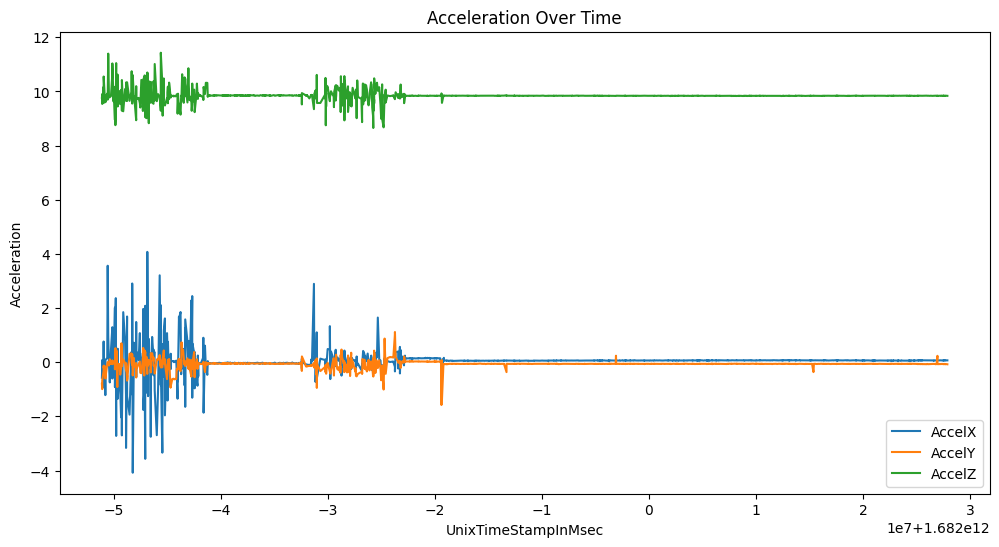

In [15]:

# Data Visualization
# Plot time series data of shock and GPS parameters
plt.figure(figsize=(12, 6))
plt.plot(combined_data_set1['UnixTimeStampInMsec'], combined_data_set1['AccelX'], label='AccelX')
plt.plot(combined_data_set1['UnixTimeStampInMsec'], combined_data_set1['AccelY'], label='AccelY')
plt.plot(combined_data_set1['UnixTimeStampInMsec'], combined_data_set1['AccelZ'], label='AccelZ')
plt.xlabel('UnixTimeStampInMsec')
plt.ylabel('Acceleration')
plt.title('Acceleration Over Time')
plt.legend()
plt.show()


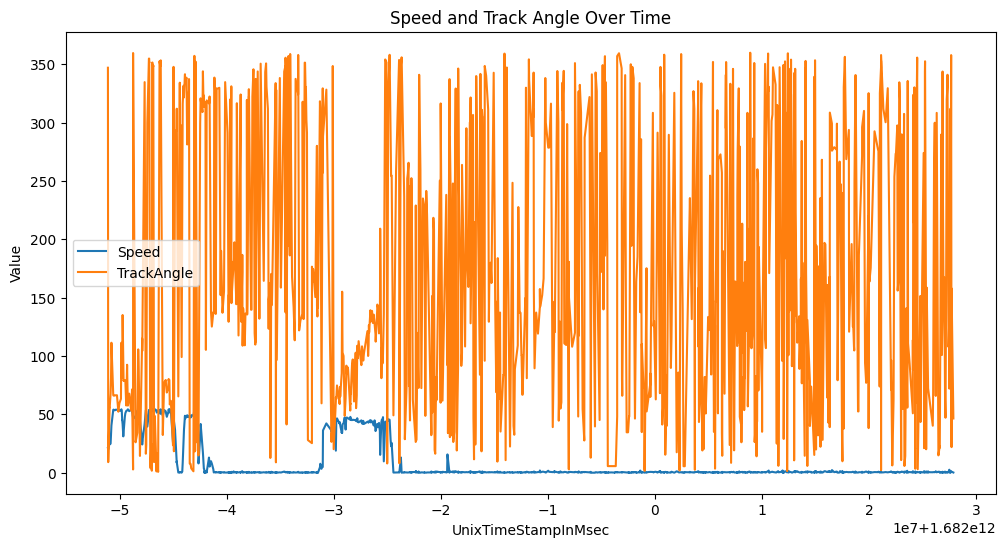

In [16]:
# Plot speed and track angle
plt.figure(figsize=(12, 6))
plt.plot(combined_data_set1['UnixTimeStampInMsec'], combined_data_set1['Speed'], label='Speed')
plt.plot(combined_data_set1['UnixTimeStampInMsec'], combined_data_set1['TrackAngle'], label='TrackAngle')
plt.xlabel('UnixTimeStampInMsec')
plt.ylabel('Value')
plt.title('Speed and Track Angle Over Time')
plt.legend()
plt.show()

d:\MyWorkspace\ShockSensorAnalysis\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\MyWorkspace\ShockSensorAnalysis\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\MyWorkspace\ShockSensorAnalysis\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\MyWorkspace\ShockSensorAnalysis\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_

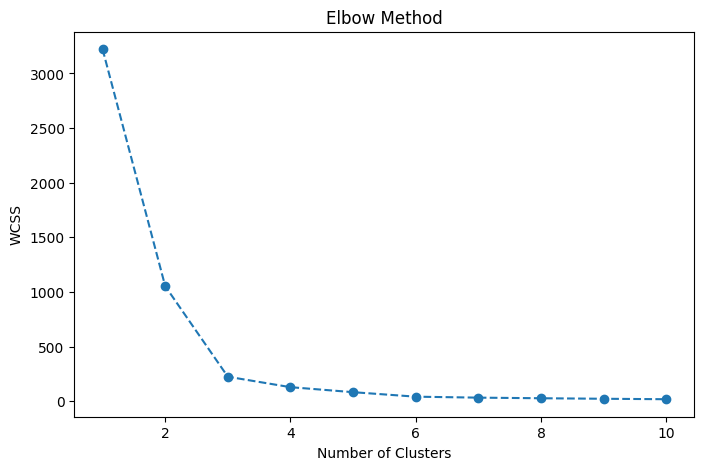

d:\MyWorkspace\ShockSensorAnalysis\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


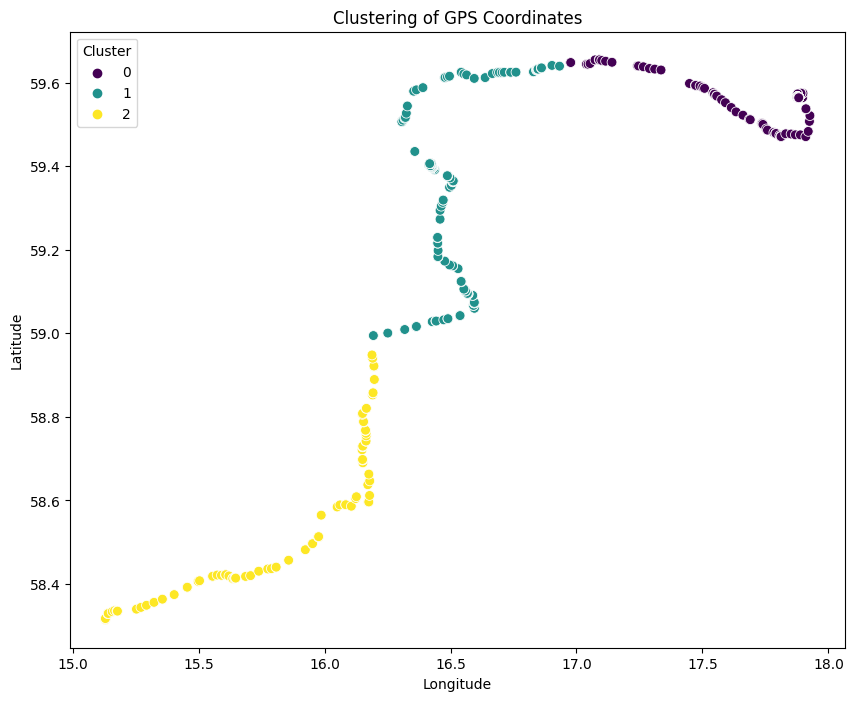

In [17]:
# Perform K-means clustering on data (Latitude and Longitude)
clustered_data = combined_data_set1[['Latitude', 'Longitude']]

# Standardize the data
scaler = StandardScaler()
merged_gps_data_scaled = scaler.fit_transform(clustered_data)

# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(merged_gps_data_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Based on the Elbow method, choose an appropriate number of clusters and fit the K-means model
num_clusters = 3  # You can adjust this based on the Elbow plot
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
combined_data_set1['Cluster'] = kmeans.fit_predict(merged_gps_data_scaled)

# Visualize the clusters on a map
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Cluster', data=combined_data_set1, palette='viridis', s=50)
plt.title('Clustering of GPS Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
